In [12]:
import sys
import os
import numpy as np
import pickle
from PIL import Image
import matplotlib.pyplot as plt

PROJECT_ROOT = os.path.abspath(os.path.join(os.path.abspath('..'),os.pardir))
numericalExperimentsPath = os.path.abspath('..')

sys.path.append(PROJECT_ROOT)

from electronTransportCode.MCEstimator import DoseEstimator
from electronTransportCode.ParticleModel import SimplifiedEGSnrcElectron
from electronTransportCode.MCParticleTracer import KDMC, AnalogParticleTracer
from lungSetup import LungInitialConditions, LungSimulationDomain, I_BONE
from electronTransportCode.ProjectUtils import E_THRESHOLD, ERE

%matplotlib widget

In [13]:

# Load particle tracers
analogTracer3d: AnalogParticleTracer = pickle.load(open('data/analogTracer3d.pkl', 'rb'))
analogTracer2d = pickle.load(open('data/analogTracer2d.pkl', 'rb'))
kdr3d = pickle.load(open('data/kdr3d.pkl', 'rb'))
doseEstimatorK3d: DoseEstimator = pickle.load(open('data/doseEstimatorK3d.pkl', 'rb'))[0]
doseEstimatorK2d = pickle.load(open('data/doseEstimatorK2d.pkl', 'rb'))[0]
doseEstimatorKDR3d = pickle.load(open('data/doseEstimatorKDR3d.pkl', 'rb'))[0]
simDomain: LungSimulationDomain = analogTracer3d.simDomain
simOptions: LungInitialConditions = analogTracer3d.simOptions
bins = simDomain.xbins
width = simDomain.width

/tmp/ipykernel_23030/3865194923.py:4: DeprecationWarning: Please use `RegularGridInterpolator` from the `scipy.interpolate` namespace, the `scipy.interpolate.interpolate` namespace is deprecated.
  kdr3d = pickle.load(open('data/kdr3d.pkl', 'rb'))


In [14]:
print(analogTracer2d.averageNbCollisions)
print(analogTracer3d.averageNbCollisions)

80486.70479999998
79322.58223999987


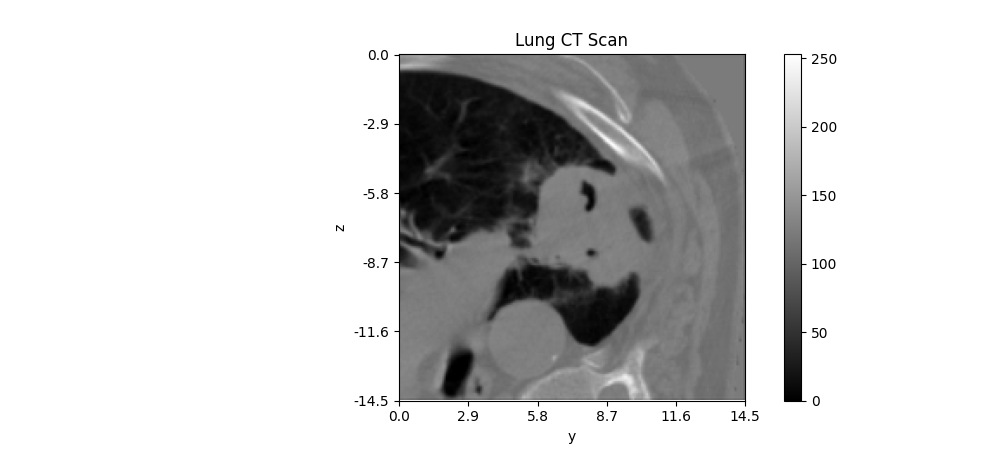

In [15]:
fig, ax1 = plt.subplots(figsize=(10, 4.5))
pos = ax1.imshow(Image.fromarray(simDomain.grayScaleImage), cmap='gray')  # type: ignore
ax1.set_title('Lung CT Scan')
ax1.set_xlabel('y')
ax1.set_ylabel('z')
nticks = 6
ax1.set_xticks(np.linspace(0, bins, nticks))
ax1.set_xticklabels(np.linspace(0, width, nticks))
ax1.set_yticks(np.linspace(0, bins, nticks))
ax1.set_yticklabels(np.linspace(0, -width, nticks))
fig.colorbar(pos, ax=ax1)


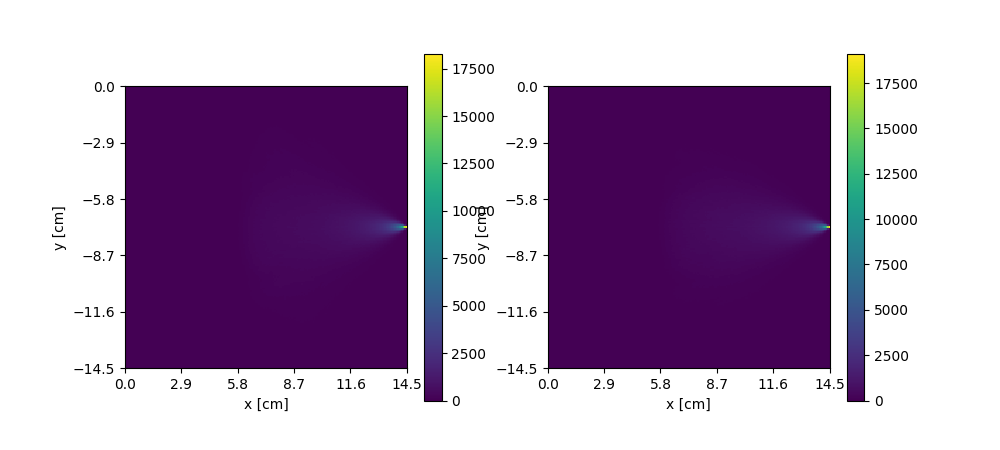

In [16]:
# Plot energy deposition in a subdomain
xBins = np.linspace(0, width, bins+1)
yBins = np.linspace(-width, 0, bins+1)

energyDepositionK3d_ERE = np.flipud(np.reshape(doseEstimatorK3d.scoreMatrix, (bins, bins)))
energyDepositionK2d_ERE = np.flipud(np.reshape(doseEstimatorK2d.scoreMatrix, (bins, bins)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.5))

pox1 = ax1.matshow(energyDepositionK3d_ERE, extent=[xBins.min(), xBins.max(), yBins.min(), yBins.max()])
ax1.set_xticks(np.linspace(xBins.min(), xBins.max(), nticks))
ax1.set_yticks(np.linspace(yBins.max(), yBins.min(), nticks))
ax1.xaxis.tick_bottom()
ax1.set_xlabel('x [cm]')
ax1.set_ylabel('y [cm]')
fig.colorbar(pox1, ax=ax1)

pox2 = ax2.matshow(energyDepositionK2d_ERE, extent=[xBins.min(), xBins.max(), yBins.min(), yBins.max()])
ax2.set_xticks(np.linspace(xBins.min(), xBins.max(), nticks))
ax2.set_yticks(np.linspace(yBins.max(), yBins.min(), nticks))
ax2.xaxis.tick_bottom()
ax2.set_xlabel('x [cm]')
ax2.set_ylabel('y [cm]')
fig.colorbar(pox2, ax=ax2)


/tmp/ipykernel_23030/1127839371.py:9: RuntimeWarning: divide by zero encountered in log
  ax1.contourf(X, Y, np.log(energyDepositionK3d_ERE), alpha=0.5, extent=extent, cmap='plasma', levels=levels)
/tmp/ipykernel_23030/1127839371.py:13: RuntimeWarning: divide by zero encountered in log
  ax2.contourf(X, Y, np.log(energyDepositionK2d_ERE), alpha=0.5, extent=extent, levels=levels, cmap='plasma')


Text(0.5, 1.0, '2d simulation')

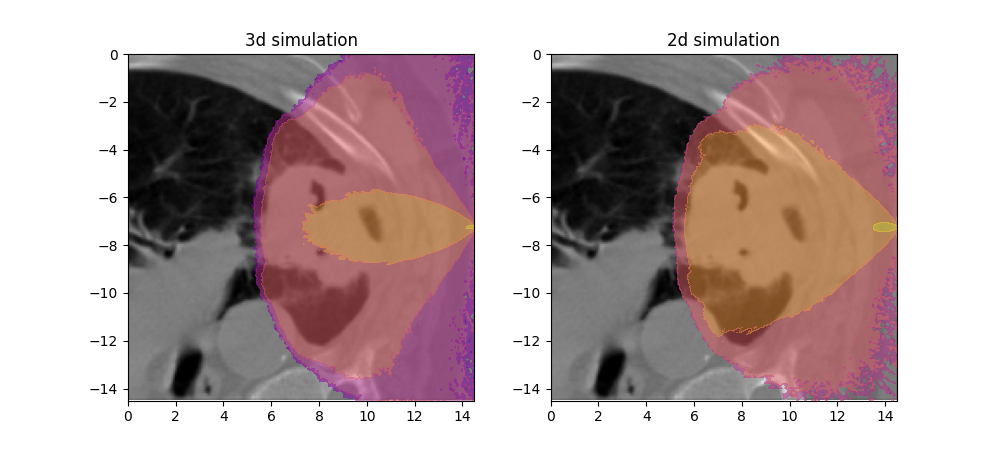

In [17]:
extent = [xBins.min(), xBins.max(), yBins.min(), yBins.max()]
xBins1 = np.linspace(0, width, bins)
yBins1 = np.linspace(-width, 0, bins)
X, Y = np.meshgrid(xBins1, yBins1)
levels = 5
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.5))

ax1.imshow(Image.fromarray(simDomain.grayScaleImage), cmap='gray', extent=extent)  # type: ignore
ax1.contourf(X, Y, np.log(energyDepositionK3d_ERE), alpha=0.5, extent=extent, cmap='plasma', levels=levels)
ax1.set_title('3d simulation')

ax2.imshow(Image.fromarray(simDomain.grayScaleImage), cmap='gray', extent=extent)  # type: ignore
ax2.contourf(X, Y, np.log(energyDepositionK2d_ERE), alpha=0.5, extent=extent, levels=levels, cmap='plasma')
ax2.set_title('2d simulation')


/tmp/ipykernel_23030/4257792713.py:11: RuntimeWarning: divide by zero encountered in log
  ax1.contourf(X, Y, np.log(energyDepositionK3d_ERE), alpha=0.5, extent=extent, cmap='plasma', levels=levels)
/tmp/ipykernel_23030/4257792713.py:15: RuntimeWarning: divide by zero encountered in log
  ax2.contourf(X, Y, np.log(energyDepositionK2d_ERE), alpha=0.5, extent=extent, levels=levels, cmap='plasma')


Text(0.5, 1.0, '3d KDR simulation')

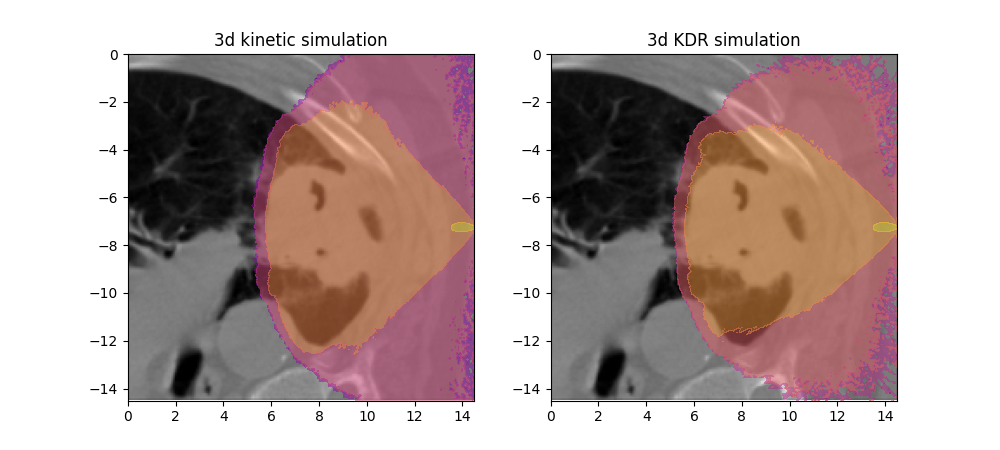

In [18]:
extent = [xBins.min(), xBins.max(), yBins.min(), yBins.max()]
xBins1 = np.linspace(0, width, bins)
yBins1 = np.linspace(-width, 0, bins)
X, Y = np.meshgrid(xBins1, yBins1)
levels = 4
energyDepositionK3dkdr_ERE = np.flipud(np.reshape(doseEstimatorK2d.scoreMatrix, (bins, bins)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.5))

ax1.imshow(Image.fromarray(simDomain.grayScaleImage), cmap='gray', extent=extent)  # type: ignore
ax1.contourf(X, Y, np.log(energyDepositionK3d_ERE), alpha=0.5, extent=extent, cmap='plasma', levels=levels)
ax1.set_title('3d kinetic simulation')

ax2.imshow(Image.fromarray(simDomain.grayScaleImage), cmap='gray', extent=extent)  # type: ignore
ax2.contourf(X, Y, np.log(energyDepositionK2d_ERE), alpha=0.5, extent=extent, levels=levels, cmap='plasma')
ax2.set_title('3d KDR simulation')


### Initial direction

In [19]:
testInit = LungInitialConditions()
N = 1000

# Sample a lot of initial vectors
vecs = np.empty((N, 3), dtype=float)
for i in range(N):
    vecs[i, :] = testInit.initialDirection()


(-1.0, 1.0)

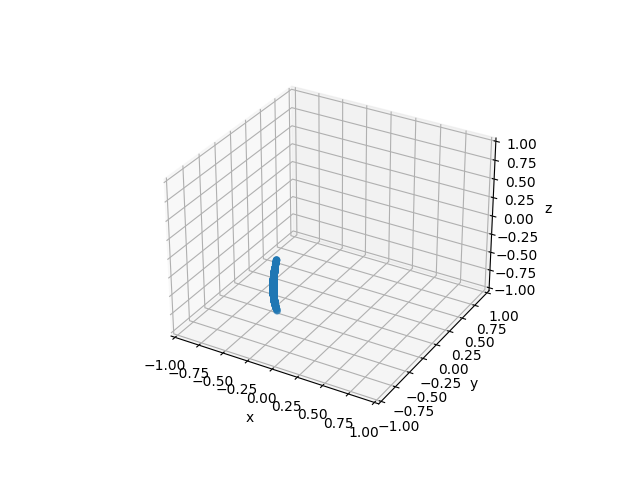

In [20]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(vecs[0:1000, 0], vecs[0:1000, 1], vecs[0:1000, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])

In [21]:
import math
import time
def test1(A_coeff, D_coeff, stepsize, vec3d):
    u, v, w = vec3d
    sint = math.sqrt(u**2 + v**2)
    cost = w
    cosphi = u/sint
    sinphi = v/sint
    R = np.array([[cosphi*cost, -sinphi, sint*cosphi], [sinphi*cost, cosphi, sinphi*sint], [-sint, 0, cost]], dtype=float)
    xi = np.random.multivariate_normal(mean=np.array((0.0, 0.0, 0.0)), cov=np.diag(np.ones((3, ))))
    new_pos3d = A_coeff*stepsize + R.dot(np.diag(np.sqrt(D_coeff)).dot(xi))
    return new_pos3d

def test2(A_coeff, D_coeff, stepsize, vec3d):
    u, v, w = vec3d
    sint = math.sqrt(u**2 + v**2)
    cost = w
    cosphi = u/sint
    sinphi = v/sint
    R = np.array([[cosphi*cost, -sinphi, sint*cosphi], [sinphi*cost, cosphi, sinphi*sint], [-sint, 0, cost]], dtype=float)
    cov = R @ np.diag(D_coeff) @ R.T
    xi = np.random.multivariate_normal(mean=np.array((0.0, 0.0, 0.0)), cov=cov)
    new_pos3d = A_coeff*stepsize + xi
    return new_pos3d


In [22]:
N = int(1e5)
A_coeff = np.array((0.1, 0.2, 0.5), dtype=float)
D_coeff = np.array((0.01, 0.05, 0.3), dtype=float)
stepsize = 0.1
vec3d = np.array((0.6, 0.2, 0.8), dtype=float)

# warmup
[test1(A_coeff, D_coeff, stepsize, vec3d) for _ in range(100)]


t1 = time.process_time()
[test1(A_coeff, D_coeff, stepsize, vec3d) for _ in range(N)]
t2 = time.process_time()
print(f'test1: {t2-t1}s')
t1 = time.process_time()
[test2(A_coeff, D_coeff, stepsize, vec3d) for _ in range(N)]
t2 = time.process_time()
print(f'test2: {t2-t1}s')


test1: 9.408232340999994s
test2: 10.103385657000004s
